In [4]:
input_file = "/data/cephfs-1/home/users/cemo10_c/work/scRNA/scRNA_preprocessing_pipeline/results/chosen_branch/adata_subset_stripped.h5ad"
output_csv = "/data/cephfs-1/home/users/cemo10_c/work/scRNA/scRNA_preprocessing_pipeline/results/chosen_branch/clusters_osca_method_subset.csv"

In [9]:
suppressPackageStartupMessages({library(SingleCellExperiment)})
sce = schard::h5ad2sce(input_file)
names(assays(sce))='counts'
logcounts(sce, withDimnames = F) = schard::h5ad2Matrix(input_file, name = "/layers/log1p_norm_of_counts")
stopifnot(!(all(assay(sce, "logcounts")[1:50]%%1 == 0))) # check values (not integer)
stopifnot(all((assay(sce, 'logcounts') |> colnames()) == (assay(sce, 'counts') |> colnames())))
stopifnot(all((assay(sce, 'logcounts') |> rownames()) == (assay(sce, 'counts') |> rownames())))

>## Chapter 5 Clustering, redux
>### 5.1 Motivation
>Basic Chapter 5 described the process of clustering cells to obtain discrete summaries of scRNA-seq datasets. Here, we describe some diagnostics to evaluate clustering separation and stability, methods to compare clusterings that represent different views of the data, and some strategies to choose the number of clusters. [We] cluster using the default graph-based method in clusterCells().

In [9]:
library(scran)
nn.clust <- clusterCells(sce, use.dimred="X_pca", full=TRUE)
colLabels(sce) <- nn.clust$clusters
sce

Loading required package: scuttle



class: SingleCellExperiment 
dim: 11449 22799 
metadata(0):
assays(2): counts logcounts
rownames(11449): NOC2L KLHL17 ... MT-ND6 MT-CYB
rowData names(7): _index mean ... dispersions dispersions_norm
colnames(22799): GTAAGAACAGCTTTCGAACGGGAA-1 TGAATGTCACAGCAACATCCCAAC-1
  ... TAACGCCTCTCCATCTATACGTCA-1 CTAACCGGTACGATTCAGTAGGCT-1
colData names(44): _index n_genes_by_counts ... cell_cycle_diff label
reducedDimNames(4): X_diffmap X_pca X_tsne X_umap
mainExpName: NULL
altExpNames(0):

>## 5.2 Quantifying clustering behavior
>### 5.2.1 Motivation
>Several metrics are available to quantify the behavior of a clustering method, such as the silhouette width or graph modularity. These metrics are most helpful when they can be computed for each cluster, allowing us to prioritize certain clusters for more careful analysis. Poorly separated clusters can be prioritized for manual inspection to determine the relevance of the differences to its neighboring clusters, while heterogeneous clusters may be subject to further clustering to identify internal structure. We can also quantify the effect of different algorithms or parameter values, providing some insight into how our dataset responds to changes in the clustering method.
>
>As an aside: it is also possible to choose the clustering that optimizes for some of these metrics. This can be helpful to automatically obtain a “reasonable” clustering, though in practice, the clustering that yields the strongest separation often does not provide the most biological insight. **Poorly separated clusters will often be observed in non-trivial analyses of scRNA-seq data where the aim is to characterize closely related subtypes or states.**

<div class="alert alert-block alert-info">
This applies to our dataset where there are no (obviously) distinct cell types.</div>

>Indeed, the most well-separated clusters are rarely interesting as these describe obvious differences between known cell types. These diagnostics are best used to guide interpretation by highlighting clusters that require more investigation rather than to filter out “bad” clusters altogether.
>
>### 5.2.2 Silhouette width
>The silhouette width is an established metric for evaluating cluster separation. For each cell, we compute the average distance to all cells in the same cluster. We also compute the average distance to all cells in another cluster, taking the minimum of the averages across all other clusters. The silhouette width for each cell is defined as the difference between these two values divided by their maximum. Cells with large positive silhouette widths are closer to other cells in the same cluster than to cells in different clusters. Thus, clusters with large positive silhouette widths are well-separated from other clusters.
>
>The silhouette width is a natural diagnostic for hierarchical clustering where the distance matrix is already available. For larger datasets, we instead use an approximate approach that uses the root of the average squared distances rather than the average distance itself. The approximation avoids the time-consuming calculation of pairwise distances that would otherwise make this metric impractical. This is implemented in the approxSilhouette() function from bluster, allowing us to quickly identify poorly separate clusters with mostly negative widths (Figure 5.1).

In [11]:
# Performing the calculations on the PC coordinates, like before.
library(bluster)
sil.approx <- approxSilhouette(reducedDim(sce, "X_pca"), clusters=colLabels(sce))
sil.approx

DataFrame with 22799 rows and 3 columns
                            cluster    other      width
                           <factor> <factor>  <numeric>
GTAAGAACAGCTTTCGAACGGGAA-1       2        12  0.0627668
TGAATGTCACAGCAACATCCCAAC-1       2        12  0.0227007
AAAGCGAAGCGATGGCATCCCAAC-1       12       9   0.1994436
ATGCGATAGTTGCGGAACAGACCT-1       2        13 -0.0291645
AACTTACTCGCTATATACAGACCT-1       2        13  0.1614254
...                             ...      ...        ...
CGAATAGGTCCACAATAGAGGCAA-1       12       5   0.0849678
ACAGGTAGTAATGCGAAACGCCGA-1       2        13  0.0315978
CTTAGCTCATCATGCTACAGTCTG-1       19       1   0.3108145
TAACGCCTCTCCATCTATACGTCA-1       3        11 -0.1525331
CTAACCGGTACGATTCAGTAGGCT-1       2        13 -0.0127003

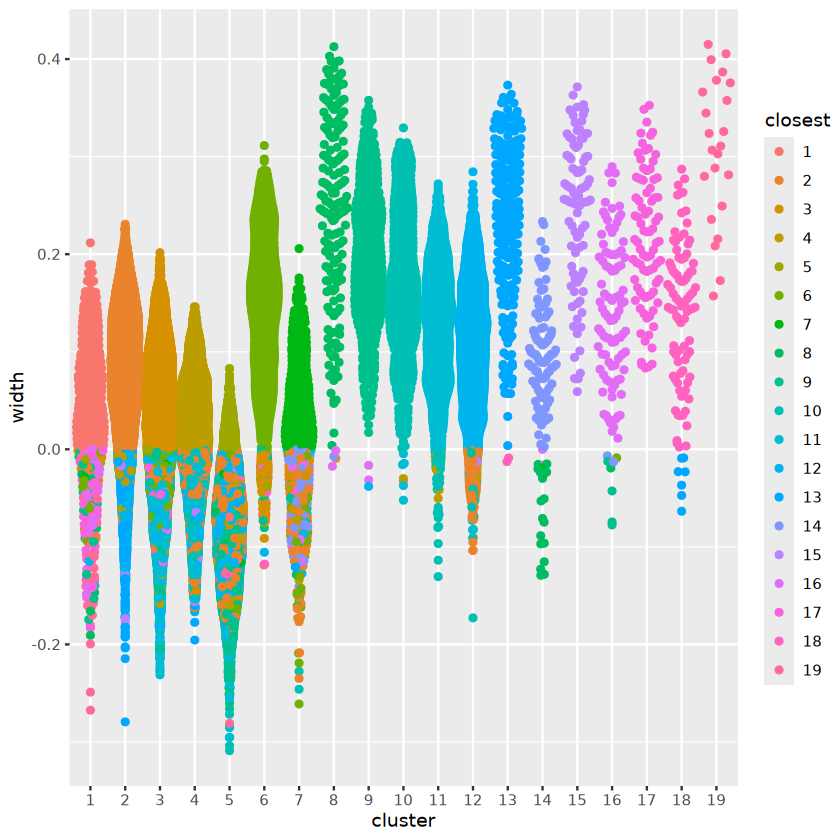

In [12]:
sil.data <- as.data.frame(sil.approx)
sil.data$closest <- factor(ifelse(sil.data$width > 0, colLabels(sce), sil.data$other))
sil.data$cluster <- colLabels(sce)

library(ggplot2)
ggplot(sil.data, aes(x=cluster, y=width, colour=closest)) +
    ggbeeswarm::geom_quasirandom(method="smiley")

>Figure 5.1: Distribution of the approximate silhouette width across cells in each cluster of the  dataset. Each point represents a cell and colored with the identity of its own cluster if its silhouette width is positive and that of the closest other cluster if the width is negative.
>
>For a more detailed examination, we identify the closest neighboring cluster for each cell in each cluster. In the table below, each row corresponds to one cluster; large off-diagonal counts indicate that its cells are easily confused with those from another cluster.

In [13]:
table(Cluster=colLabels(sce), sil.data$closest)

       
Cluster    1    2    3    4    5    6    7    8    9   10   11   12   13   14
     1   285    3    8    0    4    9    1    8   23    0    0    1    0    0
     2     0 4859    9  214    0    0    0    0    1    3    2  400  358    0
     3    11  110 2973   77   44  355    6    0  226    0  585  203    0    0
     4     0  348    4 1510    1    0    0    0    1  293  196  185   19    0
     5     6  827   92   50  283   36   29   21  552   11   55  600   48    3
     6     1    3   53    0    8 1001    1    0    9    0    0    4    0    0
     7     0   76   16   10    0   47  300    3    5    5    2    5    3   64
     8     0    1    0    0    0    0    0  182    0    0    0    0    0    1
     9     0    0    0    0    0    0    0    0  455    0    0    1    0    0
     10    0    1    0    1    0    0    0    0    0  508    5    0    0    0
     11    0    0    0    6    0    0    0    0    0   42  937    2    0    0
     12    0  123    0   18    0    0    0    0   16    

>A useful aspect of the silhouette width is that it naturally captures both underclustering and overclustering. Cells in heterogeneous clusters will have a large average distance to other cells in the same cluster; all else being equal, this will decrease their widths compared to cells in homogeneous clusters. Conversely, cells in overclustered datasets will have low average distances to cells in adjacent clusters, again resulting in low widths. One can exploit this to obtain a “sensible” initial choice for the number of clusters by maximizing the average silhouette width (Section 5.5).

>### 5.2.3 Cluster purity
>Another metric to assess cluster separation is the degree to which cells from multiple clusters intermingle in expression space. The “clustering purity” is defined for each cell as the proportion of neighboring cells that are assigned to the same cluster, after some weighting to adjust for differences in the number of cells between clusteres. Well-separated clusters should exhibit little intermingling and thus high purity values for all member cells.

In [15]:
pure <- neighborPurity(reducedDim(sce, "X_pca"), colLabels(sce))
pure

DataFrame with 22799 rows and 2 columns
                              purity  maximum
                           <numeric> <factor>
GTAAGAACAGCTTTCGAACGGGAA-1  0.600531       2 
TGAATGTCACAGCAACATCCCAAC-1  0.399719       2 
AAAGCGAAGCGATGGCATCCCAAC-1  1.000000       12
ATGCGATAGTTGCGGAACAGACCT-1  0.700562       2 
AACTTACTCGCTATATACAGACCT-1  0.773489       2 
...                              ...      ...
CGAATAGGTCCACAATAGAGGCAA-1  0.798093       12
ACAGGTAGTAATGCGAAACGCCGA-1  0.561029       2 
CTTAGCTCATCATGCTACAGTCTG-1  1.000000       19
TAACGCCTCTCCATCTATACGTCA-1  0.252210       11
CTAACCGGTACGATTCAGTAGGCT-1  0.518127       2 

>In Figure 5.2, median purity values are consistently greater than 0.9, indicating that most cells in each cluster are primarily surrounded by other cells from the same cluster. Some clusters have low purity values that may warrant more careful inspection - these probably represent closely related subpopulations.

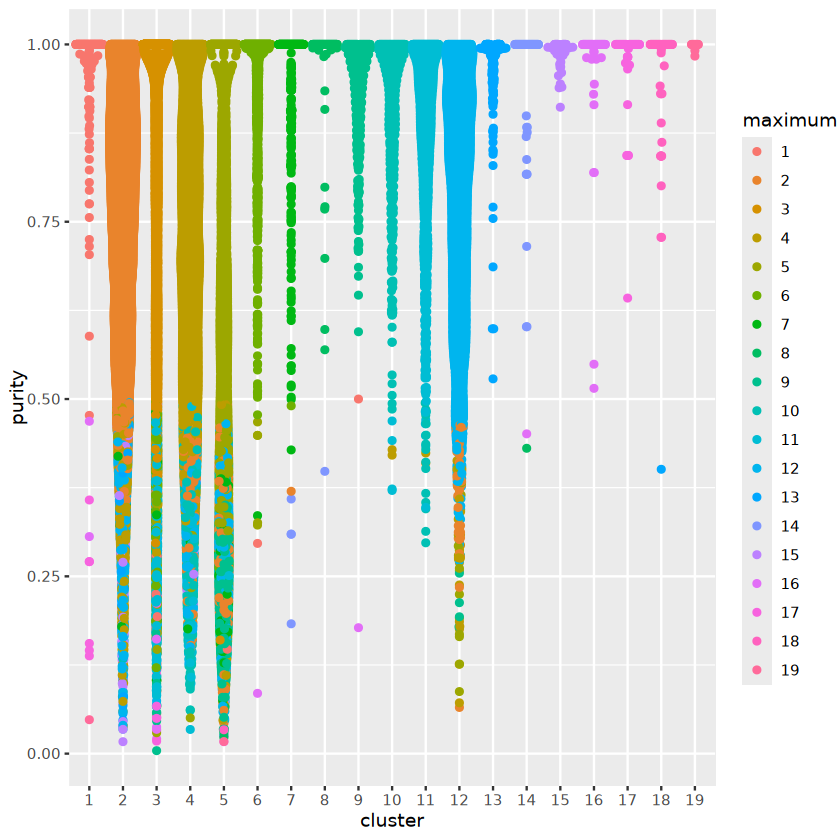

In [16]:
pure.data <- as.data.frame(pure)
pure.data$maximum <- factor(pure.data$maximum)
pure.data$cluster <- colLabels(sce)

ggplot(pure.data, aes(x=cluster, y=purity, colour=maximum)) +
    ggbeeswarm::geom_quasirandom(method="smiley")

>Figure 5.2: Distribution of cluster purities across cells in each cluster of the  dataset. Each point represents a cell and colored with the identity of the cluster contributing the largest proportion of its neighbors.
>
>To determine which clusters contaminate each other, we can identify the cluster with the most neighbors for each cell. In the table below, each row corresponds to one cluster; large off-diagonal counts indicate that its cells are easily confused with those from another cluster.

In [17]:
table(Cluster=colLabels(sce), pure.data$maximum)

       
Cluster    1    2    3    4    5    6    7    8    9   10   11   12   13   14
     1   449    0    0    0    0    0    0    0    0    0    0    0    0    0
     2     0 5178   11  286   41    0    6    0    0    3    1  280   45    0
     3    44    8 3920   10   80  227   16    0   31    0  332   49    0    0
     4     0  127    3 2063    8    0    5    0    1  189   90   79    0    0
     5     9  204   26   39 1719   24   76    7  320    8   14  202    0    2
     6     1    0    0    0    5 1079    1    0    0    0    0    0    0    0
     7     0    1    0    0    0    1  543    0    0    0    0    0    0    4
     8     0    0    0    0    0    0    0  185    0    0    0    0    0    1
     9     1    0    0    0    0    0    0    0  456    0    0    0    0    0
     10    0    0    0    2    0    0    0    0    0  509    4    0    0    0
     11    0    0    1    1    0    0    0    0    0   15  970    0    0    0
     12    0   49    1   25   15    0    0    0    7    

>The main difference between the cluster purity and silhouette width is that the former ignores the intra-cluster variance. This provides a simpler interpretation of cluster separation; a low silhouette width may still occur in well-separated clusters if the internal heterogeneity is high, while no such complication exists for the cluster purity. Comparing these two metrics can give us an indication of which clusters are heterogeneous, well-separated, or both.

>### 5.2.4 Within-cluster sum of squares
>The root-mean-squared-deviation (RMSD) for each cluster is defined pretty much as it is named - the root of the mean of the squared differences from the cluster centroid, where the mean is computed across all cells in the cluster. It is closely related to the within-cluster sum of squares (WCSS) and is a natural diagnostic for k-means clustering, given that the algorithm aims to find a clustering that minimizes the WCSS. However, it can be computed for any set of clusters if the original coordinates are available (Figure 5.3).

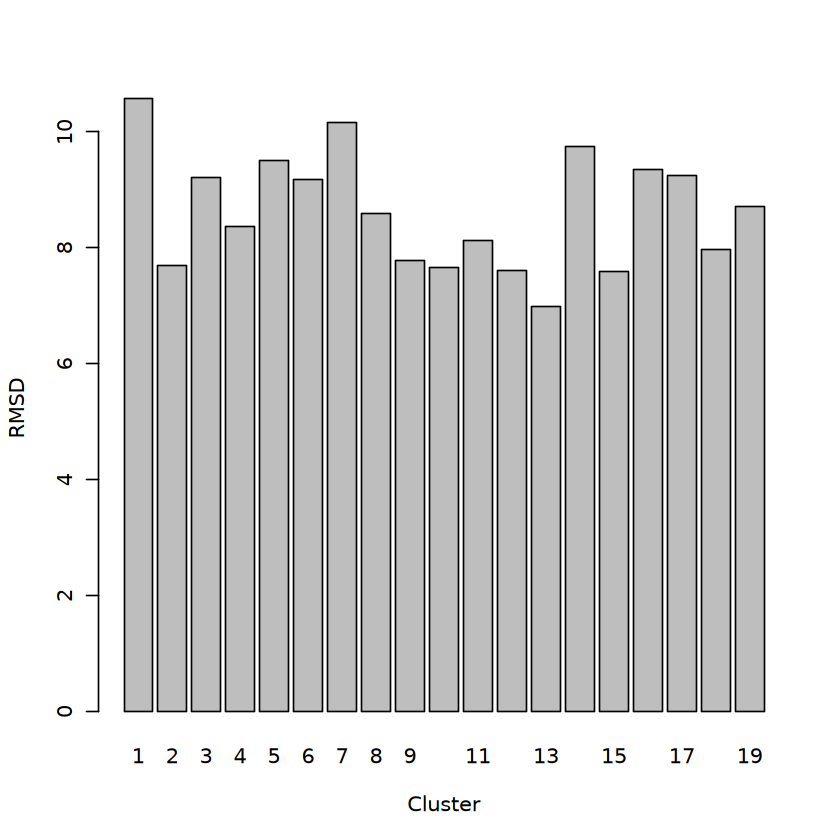

In [18]:
rmsd <- clusterRMSD(reducedDim(sce, "X_pca"), colLabels(sce))
barplot(rmsd, ylab="RMSD", xlab="Cluster")

>Figure 5.3: RMSDs for each cluster in the dataset.
>
>A large RMSD suggests that a cluster has some internal structure and should be prioritized for subclustering. Of course, this is subject to a number of caveats. Clusters generated from cells with low library sizes will naturally have larger RMSDs due to the greater impact of sequencing noise (Figure 5.4). Immediately adjacent clusters may also have high RMSDs even if they are not heterogeneous. This occurs when there are many cells on the boundaries between clusters, which would result in a higher sum of squares from the centroid.

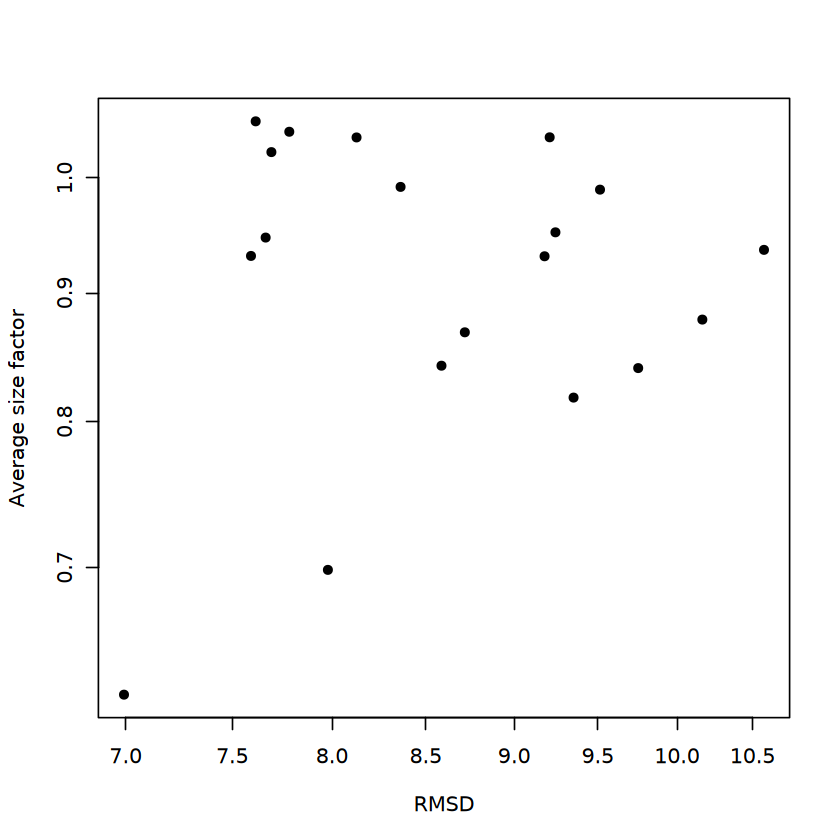

In [25]:
by.clust <- split(colData(sce)$size_factors, colLabels(sce))
sf.by.clust <- vapply(by.clust, mean, 0)
plot(rmsd, sf.by.clust, log="xy", pch=16, xlab="RMSD", ylab="Average size factor")

>Figure 5.4: RMSDs for each cluster in the dataset as a function of the average size factor.



>### 5.2.5 Using graph modularity
>For graph-based clustering, the modularity is a natural metric for evaluating the separation between communities. This is defined as the (scaled) difference between the observed total weight of edges between nodes in the same cluster and the expected total weight if edge weights were randomly distributed across all pairs of nodes. Larger modularity values indicate that there most edges occur within clusters, suggesting that the clusters are sufficiently well separated to avoid edges forming between neighboring cells in different clusters.
>
>The standard approach is to report a single modularity value for a clustering on a given graph. This is useful for comparing different clusterings on the same graph - and indeed, some community detection algorithms are designed with the aim of maximizing the modularity - but it is less helpful for interpreting a given clustering. Rather, we use the pairwiseModularity() function from bluster with as.ratio=TRUE, which returns the ratio of the observed to expected sum of weights between each pair of clusters. We use the ratio instead of the difference as the former is less dependent on the number of cells in each cluster.

In [27]:
g <- nn.clust$objects$graph
ratio <- pairwiseModularity(g, colLabels(sce), as.ratio=TRUE)
dim(ratio)

[1] 19 19

>In this matrix, each row/column corresponds to a cluster and each entry contains the ratio of the observed to total weight of edges between cells in the respective clusters. A dataset containing well-separated clusters should contain most of the observed total weight on the diagonal entries, i.e., most edges occur between cells in the same cluster. Indeed, concentration of the weight on the diagonal of (Figure 5.5) indicates that most of the clusters are well-separated, while some modest off-diagonal entries represent closely related clusters with more inter-connecting edges.

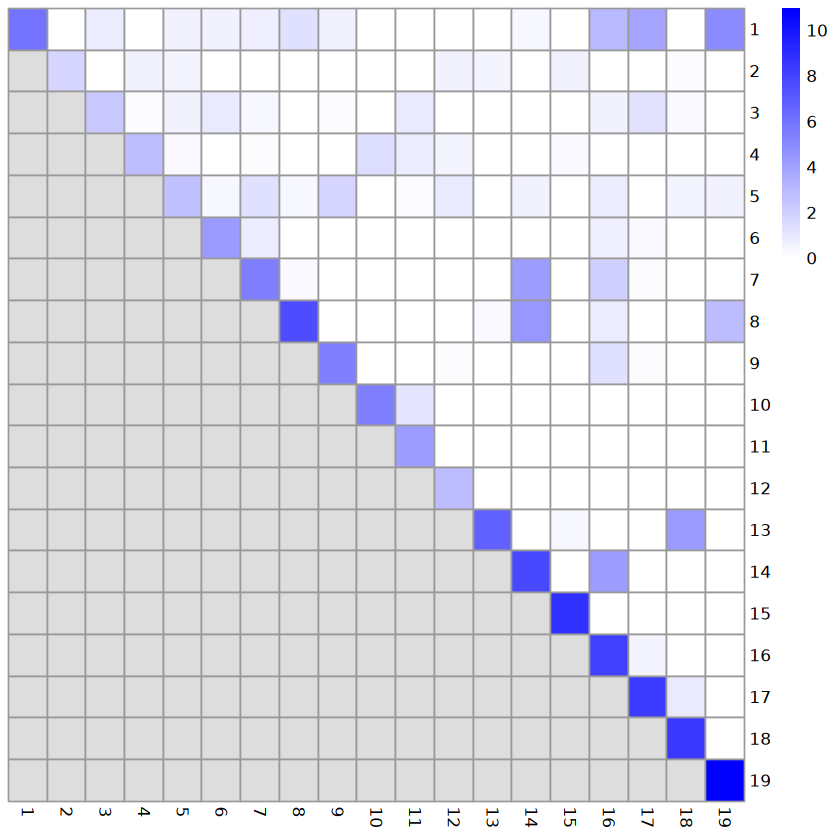

In [28]:
library(pheatmap)
pheatmap(log2(ratio+1), cluster_rows=FALSE, cluster_cols=FALSE,
    color=colorRampPalette(c("white", "blue"))(100))

>Figure 5.5: Heatmap of the log2-ratio of the total weight between nodes in the same cluster or in different clusters, relative to the total weight expected under a null model of random links.
>
>One useful approach is to use the ratio matrix to form another graph where the nodes are clusters rather than cells. Edges between nodes are weighted according to the ratio of observed to expected edge weights between cells in those clusters. We can then repeat our graph operations on this new cluster-level graph to explore the relationships between clusters. For example, we could obtain clusters of clusters, or we could simply create a new cluster-based layout for visualization (Figure 5.6). This is analogous to the “graph abstraction” approach described by Wolf et al. (2017), which can be used to identify trajectories in the data based on high-weight paths between clusters.

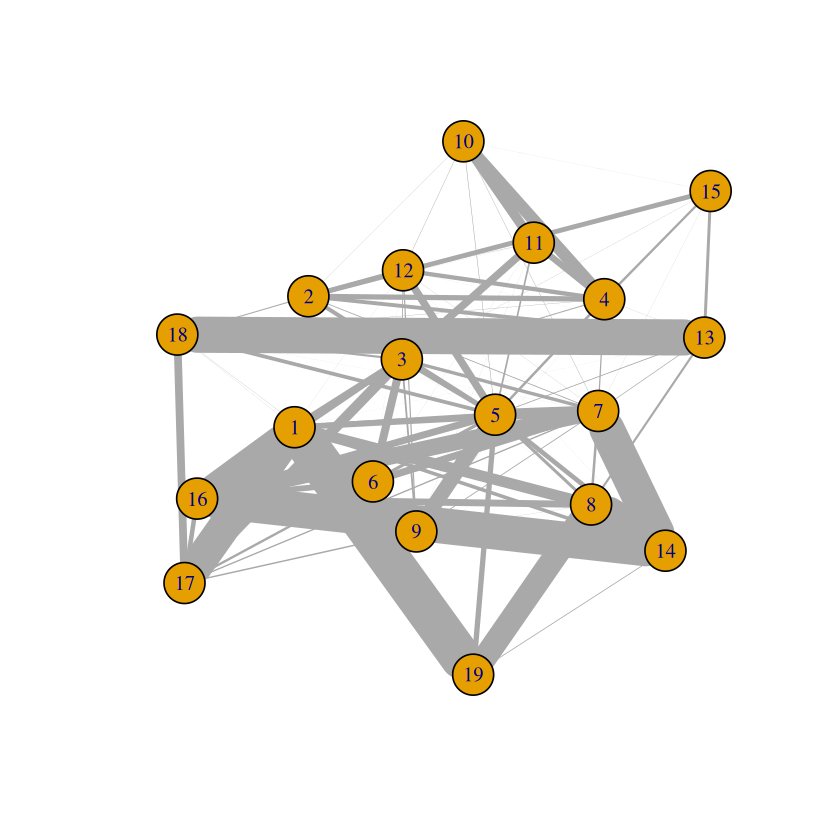

In [29]:
cluster.gr <- igraph::graph_from_adjacency_matrix(log2(ratio+1),
    mode="upper", weighted=TRUE, diag=FALSE)

# Increasing the weight to increase the visibility of the lines.
set.seed(11001010)
plot(cluster.gr, edge.width=igraph::E(cluster.gr)$weight*5,
    layout=igraph::layout_with_lgl)

>Figure 5.6: Force-based layout showing the relationships between clusters based on the log-ratio of observed to expected total weights between nodes in different clusters. The thickness of the edge between a pair of clusters is proportional to the corresponding log-ratio.
>
>Incidentally, some readers may have noticed that all igraph commands were prefixed with igraph::. We have done this deliberately to avoid bringing igraph::normalize into the global namespace. Rather unfortunately, this normalize function accepts any argument and returns NULL, which causes difficult-to-diagnose bugs when it overwrites normalize from BiocGenerics.

>## 5.3 Comparing different clusterings
>### 5.3.1 Motivation
>As previously mentioned, clustering’s main purpose is to obtain a discrete summary of the data for further interpretation. The diversity of available methods (and the subsequent variation in the clustering results) reflects the many different “perspectives” that can be derived from a high-dimensional scRNA-seq dataset. It is helpful to determine how these perspectives relate to each other by comparing the clustering results. More concretely, we want to know which clusters map to each other across algorithms; inconsistencies may be indicative of complex variation that is summarized differently by each clustering procedure. To illustrate, we will consider different variants of graph-based clustering on our dataset.

In [33]:
clust.walktrap <- clusterCells(sce, use.dimred="X_pca", 
    BLUSPARAM=NNGraphParam(cluster.fun="walktrap"))

clust.louvain <- clusterCells(sce, use.dimred="X_pca", 
    BLUSPARAM=NNGraphParam(cluster.fun="louvain"))

>### 5.3.2 Identifying corresponding clusters
>The simplest approach for comparing two clusterings of the same dataset is to create a 2-dimensional table of label frequencies. We can then identify how our Walktrap clusters are redistributed when we switch to using Louvain community detection (Figure 5.7). Multiple non-zero entries along a row or column indicate that multiple clusters in one clustering are merged in the other clustering.

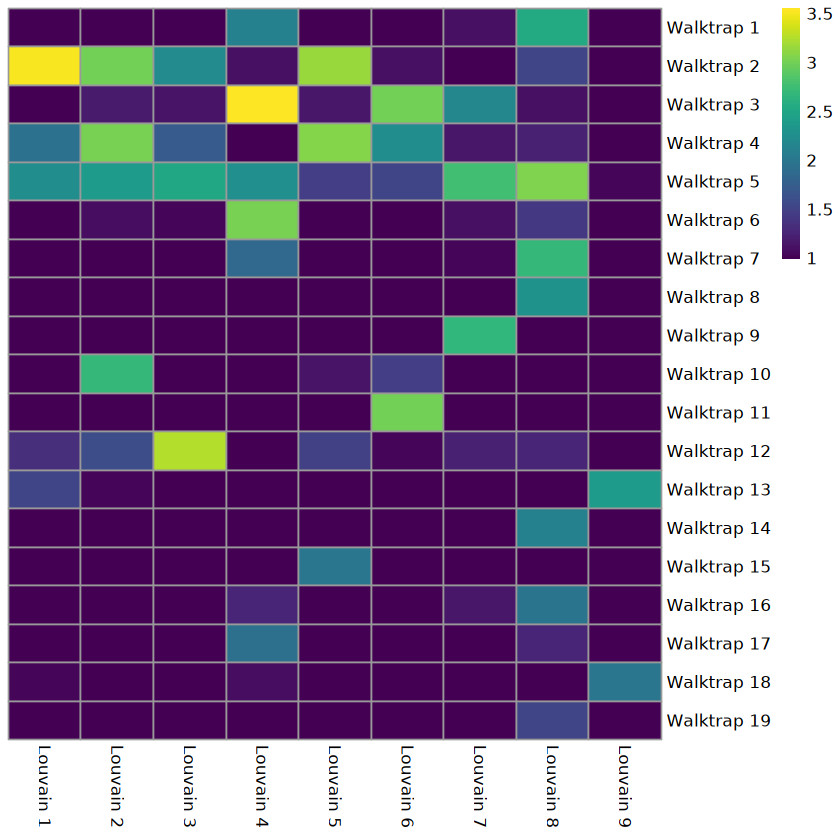

In [34]:
tab <- table(Walktrap=clust.walktrap, Louvain=clust.louvain)
rownames(tab) <- paste("Walktrap", rownames(tab))
colnames(tab) <- paste("Louvain", colnames(tab))

library(pheatmap)
pheatmap(log10(tab+10), color=viridis::viridis(100), cluster_cols=FALSE, cluster_rows=FALSE)

>Figure 5.7: Heatmap of the number of cells in each pair of clusters from Walktrap (rows) and Louvain clustering (columns) in the dataset.
>
>A more sophisticated approach involves computing the Jaccard index for each pair of clusters. This normalizes for the differences in cluster abundance so that large clusters do not dominate the color scale (Figure 5.8). Jaccard indices of 1 represent a perfect 1:1 mapping between a pair of clusters.

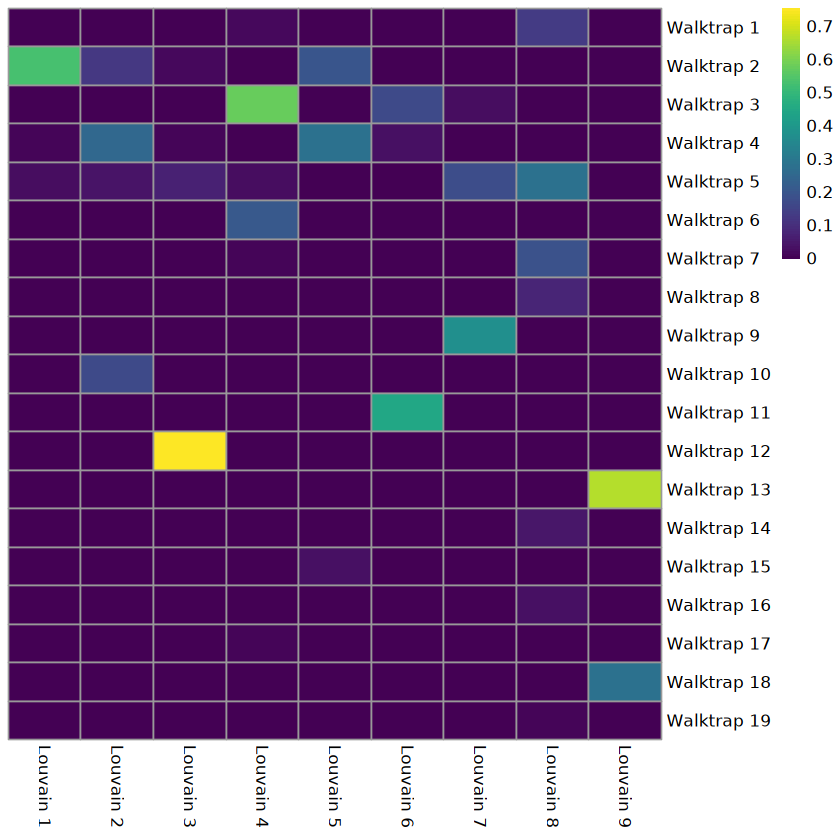

In [35]:
jacc.mat <- linkClustersMatrix(clust.walktrap, clust.louvain)
rownames(jacc.mat) <- paste("Walktrap", rownames(jacc.mat))
colnames(jacc.mat) <- paste("Louvain", colnames(jacc.mat))
pheatmap(jacc.mat, color=viridis::viridis(100), cluster_cols=FALSE, cluster_rows=FALSE)

>Figure 5.8: Heatmap of the Jaccard indices comparing each Walktrap cluster (rows) to each Louvain cluster (columns) in the dataset.
>
>We identify the best corresponding clusters based on the largest Jaccard index along each row. The magnitude of the index can be used as a measure of strength for the correspondence between those two clusters. A low index for a cluster indicates that no counterpart exists in the other clustering.

In [36]:
best <- max.col(jacc.mat, ties.method="first")
DataFrame(
    Cluster=rownames(jacc.mat), 
    Corresponding=colnames(jacc.mat)[best], 
    Index=jacc.mat[cbind(seq_len(nrow(jacc.mat)), best)]
)

DataFrame with 19 rows and 3 columns
        Cluster Corresponding      Index
    <character>   <character>  <numeric>
1    Walktrap 1     Louvain 8   0.131013
2    Walktrap 2     Louvain 1   0.528935
3    Walktrap 3     Louvain 4   0.574516
4    Walktrap 4     Louvain 5   0.285714
5    Walktrap 5     Louvain 8   0.284128
...         ...           ...        ...
15  Walktrap 15     Louvain 5 0.03310787
16  Walktrap 16     Louvain 8 0.03553922
17  Walktrap 17     Louvain 4 0.01488445
18  Walktrap 18     Louvain 9 0.28181818
19  Walktrap 19     Louvain 8 0.00944947

>### 5.3.3 Visualizing differences
>The linkClusters() function constructs a graph where nodes are clusters from multiple clusterings and edges are formed between corresponding clusters. More specifically, the weight of each edge is defined from the number of shared cells, with the Jaccard index being the potential weighting scheme used when denominator="union". The idea is to obtain “clusters of clusters”, allowing us to visualize the relationships between clusters from two or more clusterings (Figure 5.9). As the name suggests, linkClusters() is closely related to the output of the linkClustersMatrix() function; indeed, the latter simply returns part of the adjacency matrix used to create the graph in the former.

In [38]:
clust.infomap <- clusterCells(sce, use.dimred="X_pca", 
    BLUSPARAM=NNGraphParam(cluster.fun="infomap"))

linked <- linkClusters(list(
    walktrap=clust.walktrap,
    louvain=clust.louvain,
    infomap=clust.infomap)
)
linked

IGRAPH e1e231f UNW- 64 372 -- 
+ attr: name (v/c), weight (e/n)
+ edges from e1e231f (vertex names):
 [1] walktrap.2 --louvain.1 walktrap.4 --louvain.1 walktrap.5 --louvain.1
 [4] walktrap.12--louvain.1 walktrap.13--louvain.1 walktrap.18--louvain.1
 [7] walktrap.2 --louvain.2 walktrap.3 --louvain.2 walktrap.4 --louvain.2
[10] walktrap.5 --louvain.2 walktrap.6 --louvain.2 walktrap.10--louvain.2
[13] walktrap.12--louvain.2 walktrap.13--louvain.2 walktrap.2 --louvain.3
[16] walktrap.3 --louvain.3 walktrap.4 --louvain.3 walktrap.5 --louvain.3
[19] walktrap.6 --louvain.3 walktrap.12--louvain.3 walktrap.1 --louvain.4
[22] walktrap.2 --louvain.4 walktrap.3 --louvain.4 walktrap.5 --louvain.4
+ ... omitted several edges

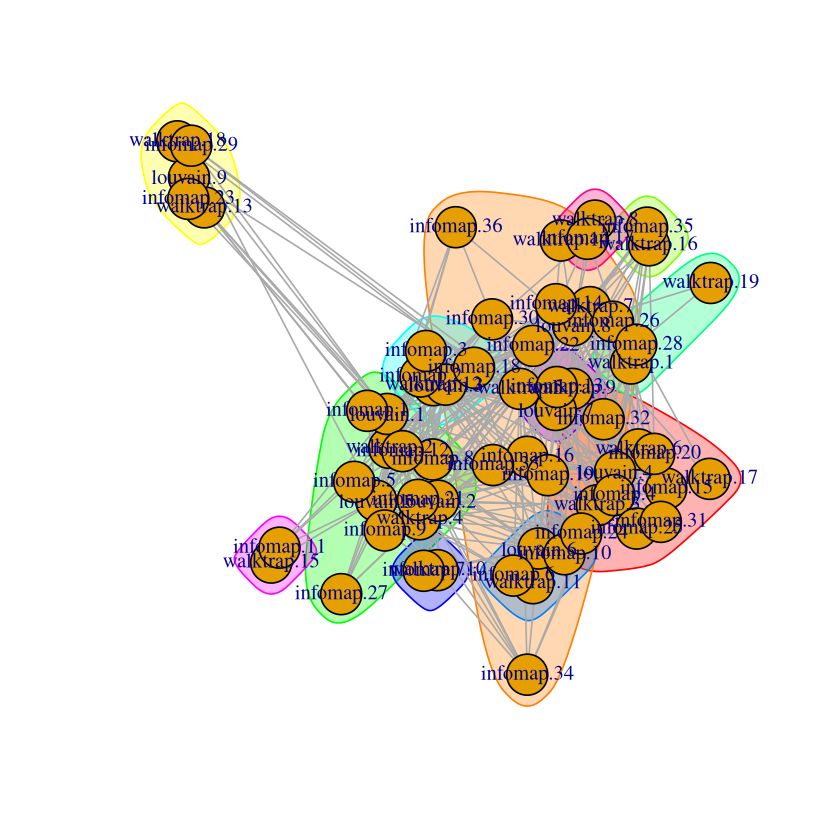

In [39]:
meta <- igraph::cluster_walktrap(linked)
plot(linked, mark.groups=meta)

>Figure 5.9: Force-directed layout of the graph of the clusters obtained from different variants of community detection on the dataset. Each node represents a cluster obtained using one comunity detection method, with colored groupings representing clusters of clusters across different methods.
>
>For clusterings that differ primarily in resolution (usually from different parameterizations of the same algorithm), we can use the clustree package to visualize the relationships between them. Here, the aim is to capture the redistribution of cells from one clustering to another at progressively higher resolution, providing a convenient depiction of how clusters split apart (Figure 5.10). This approach is most effective when the clusterings exhibit a clear gradation in resolution but is less useful for comparisons involving theoretically distinct clustering procedures.

In [ ]:
clust.5 <- clusterCells(sce, use.dimred="X_pca", BLUSPARAM=NNGraphParam(k=5))
clust.10 <- clusterCells(sce, use.dimred="X_pca", BLUSPARAM=NNGraphParam(k=10))
clust.50 <- clusterCells(sce, use.dimred="X_pca", BLUSPARAM=NNGraphParam(k=50))

combined <- cbind(k.5=clust.5, k.10=clust.10, k.50=clust.50)

In [ ]:
saveRDS(combined, "/data/cephfs-1/home/users/cemo10_c/work/scRNA/scRNA_preprocessing_pipeline/results/chosen_branch/rds/combined.rds")

In [24]:
combined = readRDS("/data/cephfs-1/home/users/cemo10_c/work/scRNA/scRNA_preprocessing_pipeline/results/chosen_branch/rds/combined.rds")

In [12]:
if("clustree" %in% rownames(installed.packages()) == FALSE) {
    install.packages("clustree")
}

Loading required package: ggraph

Loading required package: ggplot2



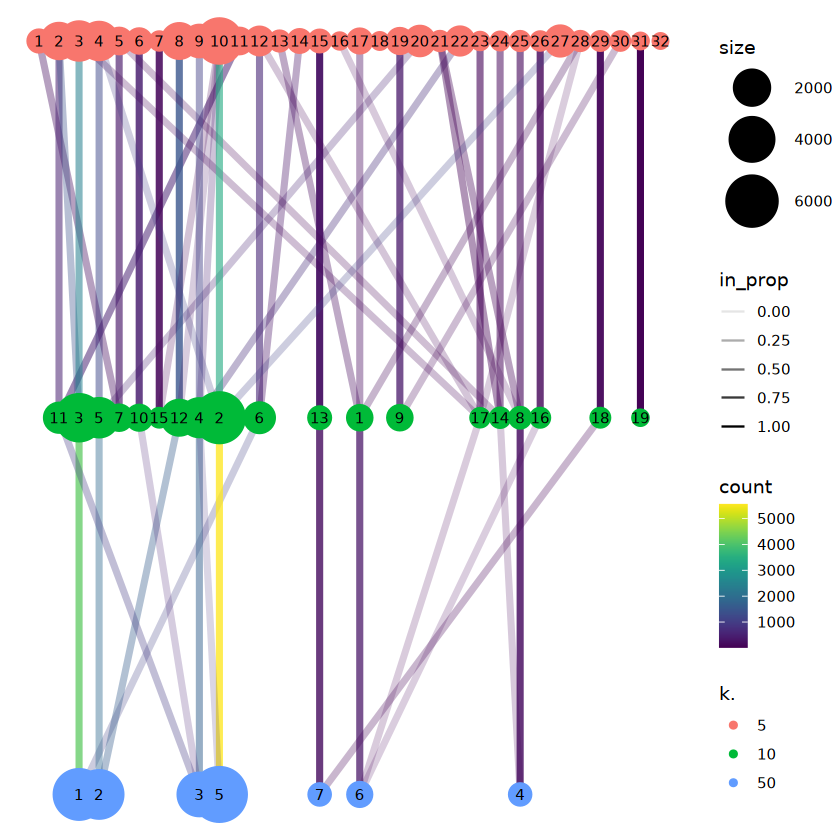

In [13]:
library(clustree)
set.seed(1111)
clustree(combined, prefix="k.", edge_arrow=FALSE)

>Figure 5.10: Graph of the relationships between the Walktrap clusterings of the dataset, generated with varying k during the nearest-neighbor graph construction. (A higher k generally corresponds to a lower resolution clustering.) The size of the nodes is proportional to the number of cells in each cluster, and the edges depict cells in one cluster that are reassigned to another cluster at a different resolution. The color of the edges is defined according to the number of reassigned cells and the opacity is defined from the corresponding proportion relative to the size of the lower-resolution cluster.

>### 5.3.4 Adjusted Rand index
>We can quantify the agreement between two clusterings by computing the Rand index with bluster’s pairwiseRand(). This is defined as the proportion of pairs of cells that retain the same status (i.e., both cells in the same cluster, or each cell in different clusters) in both clusterings. In practice, we usually compute the adjusted Rand index (ARI) where we subtract the number of concordant pairs expected under random permutations of the clusterings; this accounts for differences in the size and number of clusters within and between clusterings. A larger ARI indicates that the clusters are preserved, up to a maximum value of 1 for identical clusterings. In and of itself, the magnitude of the ARI has little meaning, and it is best used to assess the relative similarities of different clusterings (e.g., “Walktrap is more similar to Louvain than either are to Infomap”). Nonetheless, if one must have a hard-and-fast rule, experience suggests that an ARI greater than 0.5 corresponds to “good” similarity between two clusterings.

In [39]:
pairwiseRand(clust.10, clust.5, mode="index")

[1] 0.4076183

>The same function can also provide a more granular perspective with mode="ratio", where the ARI is broken down into its contributions from each pair of clusters in one of the clusterings. This mode is helpful if one of the clusterings - in this case, clust - is considered to be a “reference”, and the aim is to quantify the extent to which the reference clusters retain their integrity in another clustering. In the breakdown matrix, each entry is a ratio of the adjusted number of concoordant pairs to the adjusted total number of pairs. Low values on the diagonal in Figure 5.11 indicate that cells from the corresponding reference cluster in clust are redistributed to multiple other clusters in clust.5. Conversely, low off-diagonal values indicate that the corresponding pair of reference clusters are merged together in clust.5.

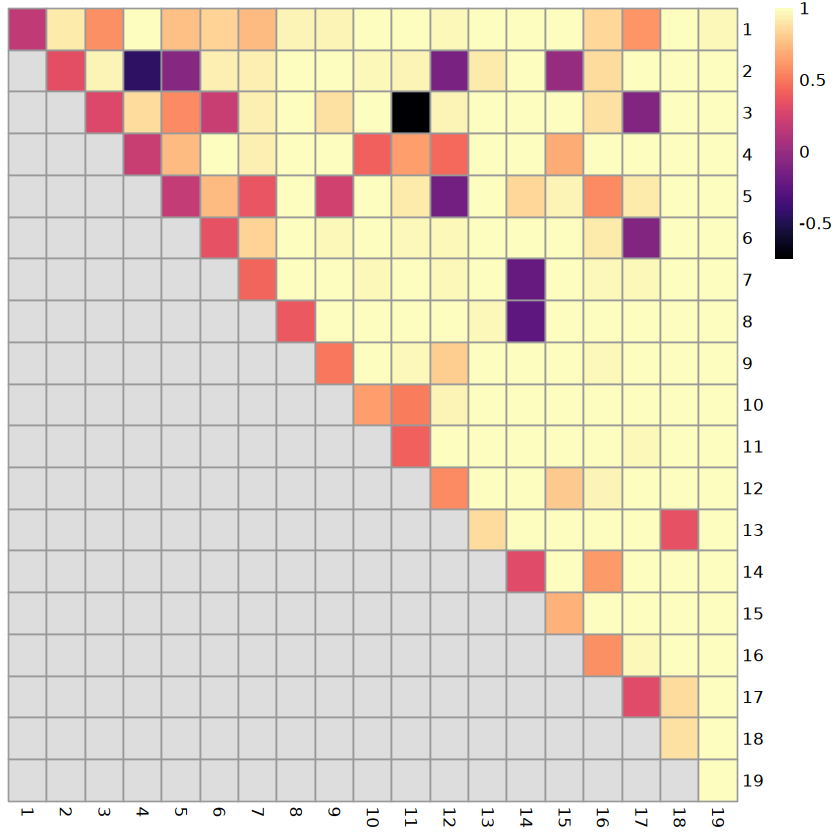

In [ ]:
breakdown <- pairwiseRand(ref=clust.10, alt=clust.5, mode="ratio")
pheatmap(breakdown, color=viridis::magma(100),
    cluster_rows=FALSE, cluster_cols=FALSE)

>Figure 5.11: ARI-based ratio for each pair of clusters in the reference Walktrap clustering compared to a higher-resolution alternative clustering for the dataset. Rows and columns of the heatmap represent clusters in the reference clustering. Each entry represents the proportion of pairs of cells involving the row/column clusters that retain the same status in the alternative clustering.

>## 5.4 Evaluating cluster stability
>A desirable property of a given clustering is that it is stable to perturbations to the input data (Von Luxburg 2010). Stable clusters are logistically convenient as small changes to upstream processing will not change the conclusions; greater stability also increases the likelihood that those conclusions can be reproduced in an independent replicate study. scran uses bootstrapping to evaluate the stability of a clustering algorithm on a given dataset - that is, cells are sampled with replacement to create a “bootstrap replicate” dataset, and clustering is repeated on this replicate to see if the same clusters can be reproduced. We demonstrate below for graph-based clustering on the PCs of the dataset.

In [42]:
myClusterFUN <- function(x) {
    g <- bluster::makeSNNGraph(x, type="jaccard")
    igraph::cluster_louvain(g)$membership
}

pcs <- reducedDim(sce, "X_pca")
originals <- myClusterFUN(pcs)
table(originals) # inspecting the cluster sizes.

originals
   1    2    3    4    5    6    7    8    9   10   11   12   13 
2130 2768 1980 4924 3506 2147   89 1421 1130 1026  329  836  513 

In [43]:
set.seed(0010010100)
ratios <- bootstrapStability(pcs, FUN=myClusterFUN, clusters=originals)
dim(ratios)

Warning message in (function (to_check, X, clust_centers, clust_info, dtype, nn, :
“detected tied distances to neighbors, see ?'BiocNeighbors-ties'”
Warning message in (function (to_check, X, clust_centers, clust_info, dtype, nn, :
“detected tied distances to neighbors, see ?'BiocNeighbors-ties'”
Warning message in (function (to_check, X, clust_centers, clust_info, dtype, nn, :
“detected tied distances to neighbors, see ?'BiocNeighbors-ties'”
Warning message in (function (to_check, X, clust_centers, clust_info, dtype, nn, :
“detected tied distances to neighbors, see ?'BiocNeighbors-ties'”
Warning message in (function (to_check, X, clust_centers, clust_info, dtype, nn, :
“detected tied distances to neighbors, see ?'BiocNeighbors-ties'”
Warning message in (function (to_check, X, clust_centers, clust_info, dtype, nn, :
“detected tied distances to neighbors, see ?'BiocNeighbors-ties'”
Warning message in (function (to_check, X, clust_centers, clust_info, dtype, nn, :
“detected tied distance

[1] 13 13

>The function returns a matrix of ARI-derived ratios for every pair of original clusters in originals (Figure 5.12), averaged across bootstrap iterations. High ratios indicate that the clustering in the bootstrap replicates are highly consistent with that of the original dataset. More specifically, high ratios on the diagonal indicate that cells in the same original cluster are still together in the bootstrap replicates, while high ratios off the diagonal indicate that cells in the corresponding cluster pair are still separated.

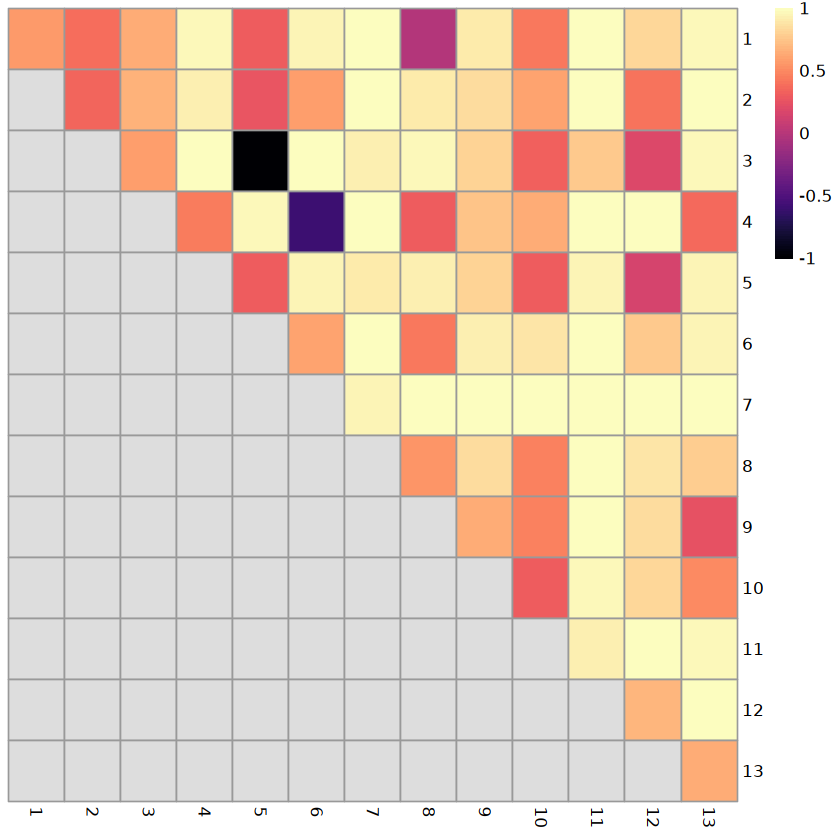

In [44]:
pheatmap(ratios, cluster_row=FALSE, cluster_col=FALSE,
    color=viridis::magma(100), breaks=seq(-1, 1, length.out=101))

>Figure 5.12: Heatmap of ARI-derived ratios from bootstrapping of graph-based clustering in the dataset. Each row and column represents an original cluster and each entry is colored according to the value of the ARI ratio between that pair of clusters.
>
>Bootstrapping is a general approach for evaluating cluster stability that is compatible with any clustering algorithm. The ARI-derived ratio between cluster pairs is also more informative than a single stability measure for all/each cluster as the former considers the relationships between clusters, e.g., unstable separation between X and Y does not penalize the stability of separation between X and another cluster Z. However, one should take these metrics with a grain of salt, as bootstrapping only considers the effect of sampling noise and ignores other factors that affect reproducibility in an independent study (e.g., batch effects, donor variation). In addition, it is possible for a poor separation to be highly stable, so highly stable cluster may not necessarily represent some distinct subpopulation.

>## 5.5 Clustering parameter sweeps
>The clusterSweep() function allows us to quickly apply our clustering with a range of different parameters. For example, we can iterate across different combinations of k and community detection algorithms for graph-based clustering. We could then use linkClusters(), clustree or similar functions to visualize the relationships between different clusterings.

In [ ]:
# Parallelizing for some speed.
out <- clusterSweep(reducedDim(sce, "X_pca"), 
    NNGraphParam(), 
    k=as.integer(c(5, 10, 15, 20, 25, 30, 35, 40)),
    cluster.fun=c("louvain", "walktrap", "infomap"),
    BPPARAM=BiocParallel::MulticoreParam(8))

colnames(out$clusters)

In [ ]:
table(out$clusters$k.5_cluster.fun.walktrap)

>Parameter sweeps are particularly useful when combined with one of the metrics described in Section 5.2. This provides a high-level summary of the behavior of the clustering method as the parameters change, as demonstrated in Figure 5.13. We can then make some decisions on which clustering(s) to use for further analyses. For example, we might choose a few clusterings that span several different resolutions, so as to obtain a greater diversity of summaries of the data; conversely, we might be able to save some time and effort by ignoring redundant clusterings with similar values for our metrics.

In [ ]:
df <- as.data.frame(out$parameters)
df$num.clusters <- vapply(as.list(out$clusters), function(cluster) { 
    length(unique(cluster))
}, 0L)

all.sil <- lapply(as.list(out$clusters), function(cluster) {
    sil <- approxSilhouette(reducedDim(sce), cluster)
    mean(sil$width)
})
df$silhouette <- unlist(all.sil)

all.wcss <- lapply(as.list(out$clusters), function(cluster) {
    sum(clusterRMSD(reducedDim(sce), cluster, sum=TRUE), na.rm=TRUE)
})
df$wcss <- unlist(all.wcss)

library(ggplot2)
gridExtra::grid.arrange(
    ggplot(df, aes(x=k, y=num.clusters, group=cluster.fun, color=cluster.fun)) + 
        geom_line(lwd=2) + scale_y_log10(),
    ggplot(df, aes(x=k, y=silhouette, group=cluster.fun, color=cluster.fun)) + 
        geom_line(lwd=2),
    ggplot(df, aes(x=k, y=wcss, group=cluster.fun, color=cluster.fun)) + 
        geom_line(lwd=2),
    ncol=3
)

>Figure 5.13: Behavior of graph-based clustering as quantified by the number of clusters (left), silhouette width (middle) and the within-cluster sum of squares (right), in response to changes in the number of neighbors k and the community detection algorithm.
>
>We could even use the sweep to automatically choose the “best” clustering by optimizing one or more of these metrics. The simplest strategy is to maximize the silhouette width, though one can imagine more complex scores involving combinations of metrics. This approach is valid but any automatic choice should be treated as a suggestion rather than a rule. As previously discussed, the clustering at the optimal value of a metric may not be the most scientifically informative clustering, given that well-separated clusters typically correspond to cell types that are already known.
>
>## 5.6 Agglomerating graph communities
>Some community detection algorithms operate by agglomeration and thus can be used to construct a hierarchical dendrogram based on the pattern of merges between clusters. The dendrogram itself is not particularly informative as it simply describes the order of merge steps performed by the algorithm; unlike the dendrograms produced by hierarchical clustering (Basic Section 5.4), it does not capture the magnitude of differences between subpopulations. However, it does provide a convenient avenue for manually tuning the clustering resolution by generating nested clusterings using the cut_at() function, as shown below.

In [ ]:
community.walktrap <- igraph::cluster_walktrap(g)
table(igraph::cut_at(community.walktrap, n=5))

In [ ]:
table(igraph::cut_at(community.walktrap, n=20))

>If cut_at()-like functionality is desired for non-hierarchical methods, bluster provides a mergeCommunities() function to retrospectively tune the clustering resolution. This function will greedily merge pairs of clusters until a specified number of clusters is achieved, where pairs are chosen to maximize the modularity at each merge step.

In [ ]:
community.louvain <- igraph::cluster_louvain(g)
table(community.louvain$membership)

In [ ]:
try(igraph::cut_at(community.louvain, n=10)) # Not hierarchical.

In [ ]:
merged <- mergeCommunities(g, community.louvain$membership, number=10)
table(merged)

>## References
>Von Luxburg, U. 2010. “Clustering Stability: An Overview.” Foundations and Trends in Machine Learning 2 (3): 235–74.
>
>Wolf, F. Alexander, Fiona Hamey, Mireya Plass, Jordi Solana, Joakim S. Dahlin, Berthold Gottgens, Nikolaus Rajewsky, Lukas Simon, and Fabian J. Theis. 2017. “Graph Abstraction Reconciles Clustering with Trajectory Inference Through a Topology Preserving Map of Single Cells.” bioRxiv. https://doi.org/10.1101/208819.